In [ ]:
import numpy as np
import pandas as pd

width = 125
print('A'*width)

np.set_printoptions(linewidth=width)
print(np.arange(width))

pandas_width = int(width * 0.84)
pd.options.display.width = pandas_width
pd.options.display.max_colwidth = pandas_width
pd.DataFrame([{'col': 'A' * (pandas_width-1)}])

# Задача
Связать записи с похожими именами
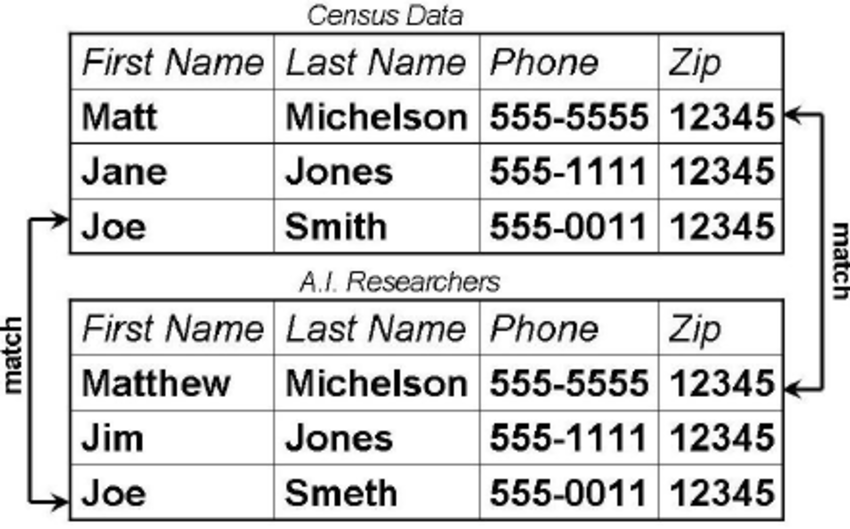



## Входные данные

In [ ]:
!wget -c "https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/room_type.csv"

In [ ]:
import pandas as pd
room = pd.read_csv('room_type.csv')
room

In [ ]:
room = room.rename(columns={'Expedia': 'exp', 'Booking.com': 'book'})
room

## Расстояния редактирования

https://en.wikipedia.org/wiki/Edit_distance

Определяется разрешёнными операциями "редактирования"

- Insertion = вставка
- Deletion = удаление
- Substitution = замена
- Transposition = перестановка

Классические расстояния:

- Левенштейна (IDS)
- LCS (Longest Common Subsequence), наибольшая общая подопоследовательность, (ID)
- Damerau–Levenshtein (IDST)
- Jaro (T)
- Hamming (S)


In [ ]:
from nltk.metrics.distance import edit_distance
edit_distance('abc', 'adc', substitution_cost=1e10), edit_distance('abc', 'adc')


In [ ]:
edit_distance('abc', 'acb'), edit_distance('abc', 'acb', transpositions=True)

In [ ]:
def my_edit_distance(a: str, b:str) -> float:
  return edit_distance(a, b) / max(len(a), len(b))

def pd_edit_distance(row: pd.Series) -> float:
  return my_edit_distance(row['exp'], row['book'])


In [ ]:
room['edit'] = room.apply(pd_edit_distance, axis=1)
room.sort_values('edit')

In [ ]:
room.edit.hist()

In [ ]:
from itertools import product
room['book_id'] = room['exp_id'] = room.index
all_pairs = pd.merge(room[['exp', 'exp_id']], room[['book', 'book_id']], how='cross')
all_pairs

In [ ]:
%time all_pairs['edit'] = all_pairs.apply(pd_edit_distance, axis=1)

In [ ]:
all_pairs.edit.hist(figsize=(6,6), bins=20)

In [ ]:
room.edit.hist(figsize=(6,6), bins=20)

In [ ]:
all_pairs.groupby('book_id').edit.min()

In [ ]:
match_id = all_pairs.groupby('book_id').edit.idxmin()
all_pairs.loc[match_id]

In [ ]:
predict_exp = all_pairs.loc[match_id].reset_index(drop=True)
predict_exp.sort_values('edit')


In [ ]:
predict_exp['match'] = predict_exp.book_id==predict_exp.exp_id

In [ ]:
import seaborn as sns
sns.histplot(predict_exp, x='edit', hue='match')

## Фонетическое соответствие
"Пылисоз" ~ "Пылесос" ?

[pɨlʲɪˈsos] - сложно и слишком точно

In [ ]:
pip install fonetika pyphonetics

In [ ]:
from pyphonetics import Soundex, Metaphone, RefinedSoundex
ph = Soundex()
print(ph.phonetics('Rupert'))
print(ph.phonetics('Robert'))
print(ph.sounds_like('Robert', 'Rupert'))
print(ph.distance('Rupert', 'Robert'))
print(ph.phonetics('assignment'))
print(ph.phonetics('assist'))
print(ph.distance('assign', 'assist'))
print(ph.distance('Rupert', 'assist'))

In [ ]:
ph = RefinedSoundex()
print(ph.phonetics('Rupert'))
print(ph.phonetics('Robert'))
print(ph.sounds_like('Robert', 'Rupert'))
print(ph.distance('Rupert', 'Robert'))
print(ph.phonetics('assign'))
print(ph.phonetics('assist'))
print(ph.distance('assign', 'assist'))
print(ph.distance('Rupert', 'assist'))
print(ph.distance('Rupert', 'assign'))

In [ ]:
ph = Metaphone()
print(ph.phonetics('Rupert'))
print(ph.phonetics('Robert'))
print(ph.sounds_like('Robert', 'Rupert'))
print(ph.distance('Rupert', 'Robert'))
print(ph.phonetics('assign'))
print(ph.phonetics('assist'))
print(ph.distance('assign', 'assist'))
print(ph.distance('Rupert', 'assist'))
print(ph.distance('Rupert', 'assign'))

In [ ]:
from fonetika.soundex import RussianSoundex

soundex = RussianSoundex()
soundex.transform('пылесос'), soundex.transform('пылисоз'), soundex.transform('пылеззос')


In [ ]:
from fonetika.distance import PhoneticsInnerLanguageDistance

phon_distance = PhoneticsInnerLanguageDistance(RussianSoundex(delete_first_letter=True))
[phon_distance.distance('ёлочка', 'йолочка'),
 phon_distance.distance('пылесос', 'пылисоз'),
 phon_distance.distance('пушкин', 'лермонтов'),
 phon_distance.distance('пушкин', 'порше')]


In [ ]:
room['ph_exp'] = room.exp.map(Metaphone().phonetics)
room['ph_book'] = room.book.map(Metaphone().phonetics)
room['ph_dist'] = list(map(Metaphone().distance, room.exp, room.book))
room

In [ ]:
room['ph_edit'] = list(map(edit_distance, room.ph_exp, room.ph_book))
print((room.ph_dist==room.ph_edit).all())

### Задание
- привести фонетическое расстояние к отрезку 0-1
- предсказать соответствия: для каждого book найти наиболее фонетически близкую запись из exp
- построить гистограмму правильных и неправильных соответствий, аналогичную построенной для расстояния редактирования на строках

# Переход в векторное пространство

- Расстояние между векторами
- Ускоряет поиск близких совпадений
- Позволяет использовать все инструменты машинного обучения

In [ ]:
room = room[['exp', 'book']]

## bag-of-ngrams или tf-idf

In [ ]:
from nltk import ngrams

list(ngrams('Пылесос', 3))

## CountVectorizer

In [ ]:
pd.concat((room[c] for c in room.columns), ignore_index=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

room_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3))
room_vectorizer.fit(
    pd.concat(
        (room[c] for c in room.columns),
        ignore_index=True))

In [ ]:
room_vectorizer.vocabulary_

In [ ]:
book_v = room_vectorizer.transform(room.book)
book_v

In [ ]:
exp_v = room_vectorizer.transform(room.exp)
exp_v

<img src="https://miro.medium.com/max/1912/1*YObjpgE_1qOTavYe9as-sg.png" width=600px;>

In [ ]:
from sklearn.metrics.pairwise import paired_cosine_distances
room['dist'] = paired_cosine_distances(book_v, exp_v)
room.sort_values('dist')

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min
match_id, match_distance = pairwise_distances_argmin_min(exp_v, book_v, metric='cosine')
predict_book = room.copy()
predict_book['pr_id'] = match_id
predict_book['pr_dist'] = match_distance
predict_book['pr_str'] = room.book.loc[match_id].reset_index(drop=True)
predict_book.sort_values('dist')

In [ ]:
match_id, match_distance = pairwise_distances_argmin_min(book_v, exp_v, metric='cosine')
predict_exp = room.copy()
predict_exp['pr_id'] = match_id
predict_exp['pr_dist'] = match_distance
predict_exp['pr_str'] = room.exp.loc[match_id].reset_index(drop=True)
predict_exp.sort_values('dist')

In [ ]:
print(sum(predict_exp.pr_id!=predict_exp.index))
predict_exp.loc[predict_exp.pr_id!=predict_exp.index].sort_values('dist')

In [ ]:
print(sum(predict_book.pr_id!=predict_book.index))
predict_book.loc[predict_book.pr_id!=predict_book.index].sort_values('dist')

### Задание
- вместо векторов по триграммам букв, использовать вектора по словам. Сравнить количество неправильных соответствий в результате. 

# Spark

## Установка, запуск

In [ ]:
!apt-get install -q openjdk-8-jdk-headless
!wget -c https://apache-mirror.rbc.ru/pub/apache/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!if [ ! -d spark-3.2.1-bin-hadoop3.2 ]; then tar -xzf spark-3.2.1-bin-hadoop3.2.tgz; fi
!pip install findspark

In [ ]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

## Чтение данных

In [ ]:
ls

In [ ]:
df = spark.read.csv('room_type.csv', header=True, inferSchema=True)
df.show(3, truncate=50)

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

df = df.withColumn("ExpediaId", monotonically_increasing_id() + 1)
df = df.withColumn("BookingId", monotonically_increasing_id() + 1)
df.show(5, 40)

In [ ]:
try:
  df1 = df.select('Expedia')
  df2 = df.select('Booking.com')
except Exception as e:
  print(e)

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, Row

schema = StructType([
    StructField("person.name", StringType(), True),
    StructField("person", StructType([
        StructField("name", StringType(), True),
        StructField("age", IntegerType(), True)]))
])
data = [
    ("charles", Row("chuck", 42)),
    ("lawrence", Row("larry", 73))
]
example = spark.createDataFrame(data, schema)
example.show()

In [ ]:
cols = ["person", "person.name", "`person.name`"]
example.select(cols).show()

## Расстояние Левенштейна

In [ ]:
df1 = df.select('Expedia', 'ExpediaID')
df2 = df.select('`Booking.com`', 'BookingId')
df_all = df1.crossJoin(df2)
df_all.show(4, 50)

In [ ]:
df_all.count()

In [ ]:
from pyspark.sql.functions import levenshtein, col

df_all = df_all.withColumn('levenshtein', levenshtein(col('Expedia'), col('`Booking.com`')))

In [ ]:
df_all.show(5, 50)

In [ ]:
df_all.orderBy("levenshtein").show(50, 50)

In [ ]:
df.withColumn('levenshtein', levenshtein(col('Expedia'), col('`Booking.com`'))).orderBy('levenshtein').toPandas()

In [ ]:
df_all.filter("ExpediaID == BookingId").select("Expedia", "`Booking.com`", "levenshtein").orderBy("levenshtein").show(50, 50)

## Косинусное сходство 

<img src="https://miro.medium.com/max/1912/1*YObjpgE_1qOTavYe9as-sg.png" width=600px;>

In [ ]:
df.show(20, 50)

[Tokenizer](http://spark.apache.org/docs/latest/ml-features.html#tokenizer)

In [ ]:
from pyspark.ml.feature import RegexTokenizer

try:
  regexTokenizerExpedia = RegexTokenizer(gaps=False, inputCol="Expedia", outputCol="ExpediaTokens", pattern=".")
  regexTokenizerBooking = RegexTokenizer(gaps=False, inputCol="`Booking.com`", outputCol="BookingTokens", pattern=".")

  regexTokenized = regexTokenizerExpedia.transform(df)
  regexTokenized = regexTokenizerBooking.transform(regexTokenized)

  regexTokenized.show(3, truncate=50)
except Exception as e:
  print(e)

In [ ]:
df = df.withColumnRenamed("Booking.com", "Booking")
df.printSchema()

In [ ]:
from pyspark.ml.feature import RegexTokenizer

regexTokenizerExpedia = RegexTokenizer(gaps=False, inputCol="Expedia", outputCol="ExpediaTokens", pattern=".")
regexTokenizerBooking = RegexTokenizer(gaps=False, inputCol="Booking", outputCol="BookingTokens", pattern=".")

regexTokenized = regexTokenizerExpedia.transform(df)
regexTokenized = regexTokenizerBooking.transform(regexTokenized)

regexTokenized.show(3, truncate=50)

In [ ]:
from pyspark.ml.feature import NGram

ngramExpedia = NGram(n=3, inputCol="ExpediaTokens", outputCol="ExpediaNgrams")
ngramBooking = NGram(n=3, inputCol="BookingTokens", outputCol="BookingNgrams")

ngramDF = ngramExpedia.transform(regexTokenized)
ngramDF = ngramBooking.transform(ngramDF)

ngramDF.show(3, 30)

In [ ]:
from pyspark.ml.feature import HashingTF

tfExpedia = HashingTF(inputCol="ExpediaNgrams", outputCol="ExpediaHTF", numFeatures=16384)
tfBooking = HashingTF(inputCol="BookingNgrams", outputCol="BookingHTF", numFeatures=16384)

featurizedDF = tfExpedia.transform(ngramDF)
featurizedDF = tfBooking.transform(featurizedDF)

featurizedDF.show(3, 20)

In [ ]:
expedia = featurizedDF.selectExpr("ExpediaId", "ExpediaHTF AS HTF")
booking = featurizedDF.select("BookingId", col("BookingHTF").alias("HTF"))
expedia.show(5), booking.show(5)

In [ ]:
unionHTF = expedia.select("HTF").union(booking.select("HTF"))
unionHTF.count()

In [ ]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="HTF", outputCol="features")
idfModel = idf.fit(unionHTF)

In [ ]:
allIDF = idfModel.setInputCol('ExpediaHTF').setOutputCol('ExpediaFeatures').transform(featurizedDF)
allIDF = idfModel.setInputCol('BookingHTF').setOutputCol('BookingFeatures').transform(allIDF)
allIDF.show(3)

In [ ]:
cross_IDF = allIDF.select("ExpediaID", "Expedia", "ExpediaFeatures").crossJoin(
            allIDF.select("BookingID", "Booking", "BookingFeatures"))
cross_IDF.show(10, 50), cross_IDF.count()

In [ ]:
from pyspark.ml.feature import Normalizer

normExpedia = Normalizer(inputCol="ExpediaFeatures", outputCol="ExpediaNorms")
normBooking = Normalizer(inputCol="BookingFeatures", outputCol="BookingNorms")

normDF = normExpedia.transform(cross_IDF)
normDF = normBooking.transform(normDF)

normDF.show(3, 30)

In [ ]:
from pyspark.sql.functions import udf

@udf('double')
def cosine(x, y):
  return float(x.dot(y))

result = normDF.withColumn("cosine", cosine(normDF.ExpediaNorms, normDF.BookingNorms))

In [ ]:
result.show()

In [ ]:
result.select("Expedia", "Booking", "cosine").orderBy("cosine", ascending=False).show(50, 50)

In [ ]:
result.filter("ExpediaID == BookingId").select("Expedia", "Booking", "cosine").orderBy("cosine", ascending=False).show(50, 50)

In [ ]:
result.select(result.cosine).toPandas().hist()[0][0].set_yscale('log')

In [ ]:
result.filter("ExpediaID == BookingId").select(result.cosine).toPandas().hist()[0][0].set_yscale('log')

# Задание
1. В Spark посчитать нормализованное на длину слов расстояние Левенштейна, построить гистограммы расстояний для совпадающих пар записей и всех пар записей
2. В Spark найти косинусное сходство, используя TF без IDF, построить гистограммы
3. В Spark перейти в векторное пространство по словам (вместо триграмм по симвалам) с помощью TF-IDF, найти косинусное сходство, построить гистограммы